# DDPG + PPO cooperation :: re-wheeler project for Reacher UnityML environment
---

### 1. Import the Necessary Packages

In [1]:
import torch
from task import Task, update_goal_curyctor
from alchemy.bot import Bot, BrainDescription
from alchemy.env import Env

from utils.crossexp import *

from utils.encoders import *
from utils.rnn import *
import model

from utils.replay import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

### 2. Load CONFIG :: TODO -> more implicit config ( trough .toml and all in one place, lot is now in 5th cell )

In [2]:
TOTAL_ENV = 20
STATE_SIZE = 33 - 3
ACTION_SIZE = 4
N_STEP = 10

N_HISTORY = 1#4#

N_REWARDS = 9
N_ACTORS = 1
MAX_STEPS = 70

### 3. Setup dummies ( unused feats in this environment )

In [3]:
def Encoder():
    return GlobalNormalizer(STATE_SIZE, N_HISTORY)

def Actor(encoder, ddpg=True):
    nes_layers = [encoder.out_size(), 400, 300, ACTION_SIZE]
    action_fn = lambda x: torch.tanh(x) * (3. if ddpg else 1.)
    return lambda: model.ActorFactory(nes_layers, action_fn, action_size=ACTION_SIZE, ddpg=ddpg)

def Critic(encoder):
    return lambda: model.Critic(N_ACTORS, N_REWARDS, encoder.out_size(), ACTION_SIZE, lambda x: x)

### 4. Set model wrappers

In [4]:
PPO_LOOP = 2

def callback(bot, task, test_scores, learn_scores, seeds, total):
    if 0 == total % PPO_LOOP * 2:
        bot.sync_explorer(0, 1, ["critic", "neslayer_2", "sigma_2"])
    else:
        bot.sync_explorer(1, 0, ["critic", "neslayer_2", "sigma_2"])

    if test_scores is not None:
        print("\n\t==> test round with ", len(test_scores), test_scores, np.mean(learn_scores))

def dbgout(bot, score, actions):
    return

### 5. Setup && run agent/bot

In [5]:
bs = 2048
learning_delay = MAX_STEPS * PPO_LOOP

ppo_n_envs = 18 # DDPG will just update based on cross-buff and minimal self interaction
ddpg_n_envs = TOTAL_ENV - ppo_n_envs # rest will be PPO for estimating safe zone to go

ReplayBuffer = cross_exp_buffer(TOTAL_ENV*250) # without need to recalc feats again and again, aka small one

replay_ppo = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=learning_delay * ppo_n_envs * 2, select_count=40, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=0)

replay_ddpg = ReplayBuffer(
            n_step=N_STEP, replay_reanalyze=True,
            buffer_size=MAX_STEPS * ddpg_n_envs * 100, select_count=4, max_ep_draw_count=40,
            alpha=.7, beta_base=.3, beta_end=.7, beta_horizon=10000,
            recalc_delta=3, share_exp_ratio=4)

encoder = Encoder()
brain_descriptions = [
        BrainDescription( # master :: DDPG
            ddpg=True,
            count=ddpg_n_envs, n_groups=ddpg_n_envs, Actor=Actor(encoder), Critic=Critic(encoder),
            model_path="x_coop_v1_checkpoints", save=True, load=True, delay=2,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ddpg, batch_size=128,
            sync_delta=3, learning_delay=N_STEP * 3, learning_repeat=TOTAL_ENV * 2,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=None, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=3e-5, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=False, prob_treshold=None),
        BrainDescription( # shadow :: PPO
            ddpg=False,
            count=ppo_n_envs, n_groups=ppo_n_envs, Actor=Actor(encoder, False), Critic=Critic(encoder),
            model_path="x_coop_v1_checkpoints", save=True, load=True, delay=7,
            resample_delay=N_STEP,
            good_reach=1, replay_buffer=replay_ppo, batch_size=bs,
            sync_delta=3, learning_delay=learning_delay, learning_repeat=ppo_n_envs * 7,
            fresh_frac=10, optim_epochs=3,
            ppo_eps=2e-1, dbgout=False,
            adv_on=True, adv_boost=False,
            lr_actor=3e-5, lr_critic=2e-4, clip_norm=5.,
            tau_replay_counter=1, tau_base=1e-3, tau_final=1e-3,
            replay_cleaning=True, prob_treshold=(7e-3, 1.7)),
    ]

bot = Bot(
# brain configs
        encoder,
        brain_descriptions,

        n_actors=2, n_critics=2,
        n_history=N_HISTORY, state_size=STATE_SIZE, action_size=ACTION_SIZE,
        n_step=N_STEP, floating_step=True, gamma=.99,

# agent configs
        update_goal=update_goal_curyctor(N_STEP),
        her_max_ratio=1,
        gae=True, gae_tau=.95,
        freeze_delta=3, freeze_count=3,
        )

task = Task()

env = Env(bot, task,
        total_envs=TOTAL_ENV, n_history=N_HISTORY, history_features=encoder.features_n(), state_size=encoder.in_size(),
        n_step=N_STEP, send_delta=N_STEP * 3,
        eval_limit=10, eval_ratio=.5, max_n_episode=MAX_STEPS, eval_delay=20,
        mcts_random_cap=1000, mcts_rounds=1)

bot.sync_explorer(1, 0, ["critic"])
bot.sync_target(1, 0, ["critic"])

scores = env.start(callback, dbgout)
losses_1 = bot.brains[0].get_losses()
losses_2 = bot.brains[1].get_losses()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


[   20>  1419:: 0] steps =   70, max_step =  71/ 70, reward=-0.030778 <action=[ 2.99999948  0.93414483  1.17598739 -0.36896968]>                    
	==> test round with  1 [0.39149999124929374] -0.030777777777777786
[   40>  2839:: 0] steps =   70, max_step =  71/ 70, reward=-0.006500 <action=[-2.65808991  2.95737594  2.98554252 -0.46464732]>                                   
	==> test round with  1 [1.0789999758824724] -0.0059999999999999975
[   60>  4259:: 0] steps =   70, max_step =  71/ 70, reward=0.009944 <action=[ 2.99876528 -2.38111321 -2.95182909  2.78873787]>                                     
	==> test round with  1 [1.8094999595545154] 0.010222222222222221
[   80>  5679:: 0] steps =   70, max_step =  71/ 70, reward=0.043111 <action=[-2.97814011  0.45398623  2.21050086  2.74881506]>                                    
	==> test round with  1 [4.098999908380203] 0.04422222222222223
[  100>  7099:: 0] steps =   70, max_step =  71/ 70, reward=0.035944 <action=[-2.99627345 -0

In [7]:
scores_ex = scores[1:]
scores = np.asarray(scores_ex).flatten()
losses_ex_1 = losses_1
losses_1 = np.vstack(losses_ex_1)[::(len(losses_ex_1)//200)]
losses_ex_2 = losses_2
losses_2 = np.vstack(losses_ex_2)[::(len(losses_ex_2)//300)]

### 4. Plot reward + loss

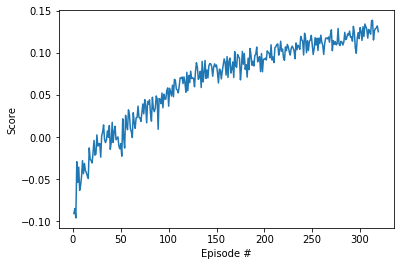

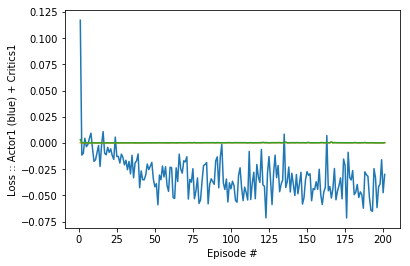

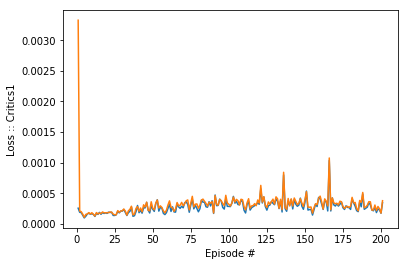

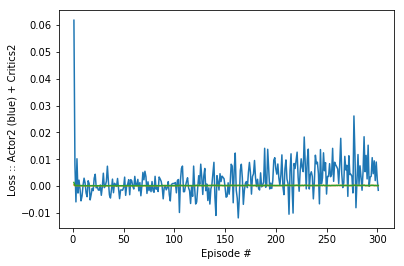

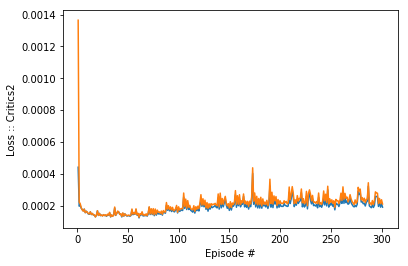

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1)
plt.ylabel('Loss :: Actor1 (blue) + Critics1')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_1)+1), losses_1[:, 1:])
plt.ylabel('Loss :: Critics1')
plt.xlabel('Episode #')
plt.show() 

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2)
plt.ylabel('Loss :: Actor2 (blue) + Critics2')
plt.xlabel('Episode #')
plt.show() 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(losses_2)+1), losses_2[:, 1:])
plt.ylabel('Loss :: Critics2')
plt.xlabel('Episode #')
plt.show() 

### 4. Reload trained agent

In [ ]:
for i in range(2):
    bot.sync_target(i, i, [])
    bot.sync_explorer(i, i, [])

### 5. Test visuals - TARGET


 environment solved!  30.959299308005733
[31.21499930229037, 30.388999320752884, 31.622999293170878, 30.31049932250757, 30.867499310057653, 31.195499302726216, 31.615499293338488, 32.17049928093327, 30.21199932470923, 29.994499329570754]

 environment solved!  31.537849295074096
[32.82399926632649, 31.094499304983703, 32.30349927796043, 31.45499929692593, 30.56599931679656, 32.12599928192793, 30.006499329302496, 31.66349929226557, 31.758999290131047, 31.580499294120806]

 environment solved!  31.357849299097417
[32.02549928417435, 31.889999287202915, 31.494999296031864, 31.065499305631903, 30.6539993148297, 30.94349930835884, 31.077999305352552, 31.581999294087286, 31.452499296981742, 31.392499298322996]

 environment solved!  31.09379930499942
[30.137999326363133, 31.057499305810854, 31.171499303262674, 31.10699930470433, 31.79749928927066, 31.233499301876886, 31.541999294981288, 30.25349932378161, 30.92499930877243, 31.71249929117031]

 environment solved!  31.16624930337999
[31.449

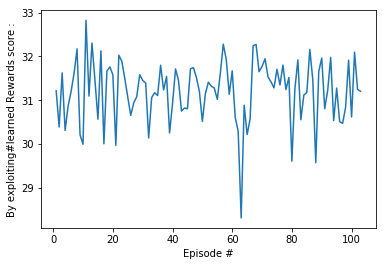

In [9]:
rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show()

### 6. Test visuals - EXPLORER


 environment solved!  30.283299323115493
[30.681499314215078, 30.57699931655074, 29.032999351061896, 30.28399932309985, 31.283499300759253, 29.578999338857905, 28.97899935226882, 31.448999297060016, 30.658499314729156, 30.308499322552244]

 environment solved!  30.34754932167943
[30.09249932738027, 30.435499319713603, 29.867999332398192, 31.14549930384396, 30.745999312773378, 30.540499317366677, 30.790499311778706, 29.928999331034703, 29.93299933094533, 29.994999329559526]

 environment solved!  30.549299317169943
[30.65349931484095, 30.938499308470725, 30.045499328430747, 29.528999339975393, 31.14099930394449, 30.315999322384474, 29.490499340835896, 31.383999298512965, 31.501499295886596, 30.49349931841722]

 environment solved!  30.479049318740152
[30.140499326307324, 30.709999313578024, 30.61199931576852, 32.52199927307671, 29.169499348010845, 29.344499344099294, 31.019999306648952, 30.727499313186843, 30.784999311901636, 29.759499334823378]

 environment solved!  30.51599931791422

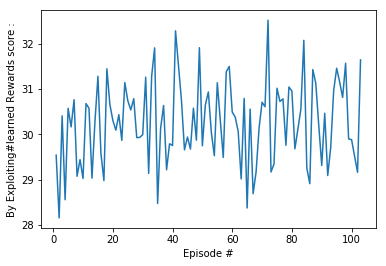

In [10]:
# for evaluation we will set target network to be explorer
bot.brains[0].ac_target = bot.brains[0].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By Exploiting#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 

### 6. Test visuals - PPO ( target network )

mean rewards :  23.79053946823999


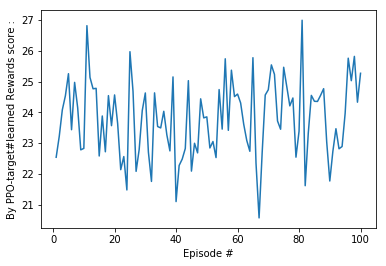

In [11]:
# ...
bot.brains[0].ac_target = bot.brains[1].ac_target

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By PPO-target#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 

### 6. Test visuals - PPO ( explorer network )

mean rewards :  21.882934510878286


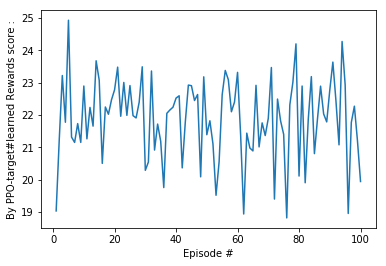

In [12]:
# ...
bot.brains[0].ac_target = bot.brains[1].ac_explorer

rewards = []
while len(rewards) < 100:
    success, scores = env.evaluate()
    for s in np.asarray(scores).flatten():
        rewards.append(s)
        
print("mean rewards : ", np.mean(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('By PPO-target#learned Rewards score :')
plt.xlabel('Episode #')
plt.show() 